In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import random
import pandas as pd
import matplotlib 
import math
from functools import reduce


matplotlib.rcParams['figure.figsize'] = (16, 16)

In [2]:
total_toss = 50
num_cluster = 2
total_experiment = 100

In [3]:
params = [
            {"pi": 0.2, "theta": [0.1, 0.6, 0.3]},
            {"pi": 0.8, "theta": [0.3, 0.2, 0.5]},
        ]

In [4]:
def coin_toss(prob, total_toss):
    result = []
    for i in range(total_toss):
        result.append(np.random.choice(len(prob), 1, p=prob)[0])
    return result

In [5]:
X = []
Z = []

for i in range(total_experiment):
    coin_type = np.random.choice(len(params), 1, p=[params[0]["pi"], params[1]["pi"]])[0]
    Z.append(coin_type)
    
    toss = coin_toss(params[coin_type]["theta"], total_toss)
    X.append(toss)

In [6]:
def multinomial_pdf(tosses, p):
    count = Counter(tosses)
    const = math.factorial(len(tosses)) / (math.factorial(count[0]) * math.factorial(count[1]))
    return const * p[0]**count[0] * p[1]**count[1]

In [7]:
random_Z = np.random.choice(len(params), total_experiment, p=[1/num_cluster for i in range(num_cluster)])

In [8]:
beta = [1, 1, 1]

In [9]:
def test(xi, cluster):
    xi_counts = Counter(xi)
    xi_sum = len(xi)
    
    cluster_counts = Counter(cluster)
    C = len(cluster)
    B = sum(beta)
    
    num = 1
    denom = 1 
    
    for k, v in cluster_counts.items():
        if k not in xi_counts:
            continue
        
        b = beta[k]
        v = v + b
        
        n = xi_counts[k]
        n_vals = [v+j for j in range(n)]
        
        n_temp = 1
        for o in n_vals:
            n_temp = n_temp * o
        num = num * n_temp
    
    C = C + B - 1 
    d_vals = [C+j for j in range(xi_sum)]
    
    d_temp = 1
    for t in d_vals:
        d_temp = d_temp * t
    
    return num/d_temp

In [10]:
A = 0.1

def calc_prob(xi, random_Z, X):
    prob = []
    z_count = Counter(random_Z)
    
    clusters = {}
    A = 1
    C = len(X)
    
    for i in range(num_cluster):
        clusters[i] = []

    for i, cx in enumerate(X):
        if cx == xi:
            continue
        clusters[random_Z[i]].extend(cx)
        
    for i in range(num_cluster):
        prob_k = test(xi, clusters[i])
        prob.append(((z_count[i] + A/num_cluster)/(total_experiment + num_cluster - 1)) * prob_k) 
        
    return prob

In [11]:
total_data_likelihood = []

for j in range(100):
    data_likelihood = []
    for i in range(len(X)):
        xi = X[i]
        final_prob = calc_prob(xi, random_Z, X)
        
        total_prob = np.sum(final_prob)
        random_Z[i] = np.random.choice(num_cluster, 1, p=[p/total_prob for p in final_prob])[0]
        data_likelihood.append(np.log(np.sum(final_prob)))
    total_data_likelihood.append(np.sum(data_likelihood))

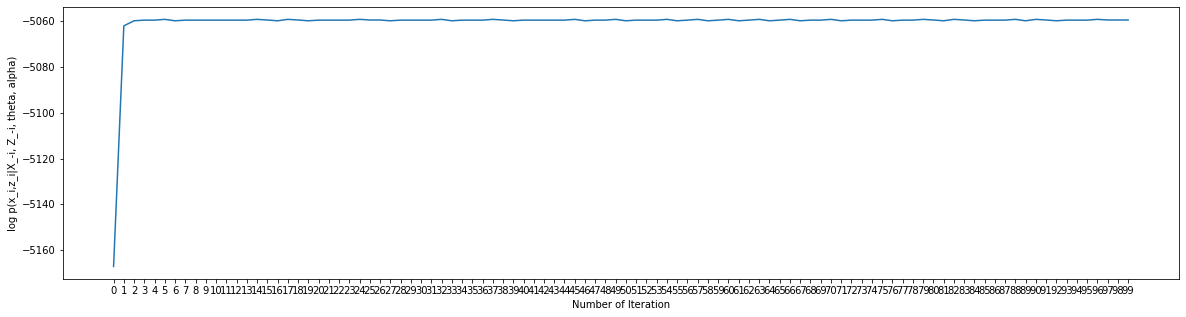

In [12]:
plt.figure(figsize=(20, 5))
plt.plot(total_data_likelihood)
plt.xlabel("Number of Iteration")
plt.ylabel("log p(x_i,z_i|X_-i, Z_-i, theta, alpha)")
plt.xticks([i for i in range(len(total_data_likelihood))])
plt.show()

In [16]:
df_list = []
for d, new_z, a_z in zip(X, random_Z, Z):
    df_list.append([d, new_z, a_z])

In [17]:
frame = pd.DataFrame(df_list, columns = ["X", "model_label", "actual_label"])

In [24]:
frame['model_label==actual_label'] = frame['model_label'] == frame['actual_label']

In [30]:
frame['model_label==actual_label'].value_counts()

True     99
False     1
Name: model_label==actual_label, dtype: int64